# Binary Classification
Uses transcript to predict presence of depression. Recall that a PHQ_Score of 10 and above is considered as depression.

# Load and Clean Data

In [1]:
import pandas as pd
import string
import re as re

df = pd.read_csv("../data/compiled_transcripts.csv")
df.Transcript = df.Transcript.apply(lambda x: re.sub('<[^<]+?>', '', x))
df.Transcript = df.Transcript.apply(lambda x: x.translate(str.maketrans("","",string.punctuation)))
df.head()

,Participant_ID,Transcript,PHQ_Score,PHQ_Binary
0,300,good atlanta georgia um my parents are from he...,2,0
1,301,thank you mmm k im doing good thank you im fro...,3,0
2,302,im fine how about yourself im from los angele...,4,0
3,303,okay how bout yourself here in california yeah...,0,0
4,304,im doing good um from los angeles california u...,6,0


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.Transcript, df.PHQ_Binary, test_size=0.2, random_state=42)

# Convert the text to sequences

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.datasets import imdb
from keras.callbacks import EarlyStopping

max_features = 5000 # only the top 5000 words are indexed when tokenized
maxlen = 80 # cut texts after this number of words
batch_size = 32 # for batch gradient descent

Using TensorFlow backend.


In [4]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

tokenizer.word_index

{'i': 1,
 'and': 2,
 'to': 3,
 'um': 4,
 'a': 5,
 'the': 6,
 'uh': 7,
 'that': 8,
 'you': 9,
 'my': 10,
 'it': 11,
 'of': 12,
 'know': 13,
 'was': 14,
 'like': 15,
 'just': 16,
 'im': 17,
 'in': 18,
 'so': 19,
 'but': 20,
 'its': 21,
 'dont': 22,
 'me': 23,
 'have': 24,
 'with': 25,
 'not': 26,
 'really': 27,
 'for': 28,
 'be': 29,
 'do': 30,
 'about': 31,
 'yeah': 32,
 'or': 33,
 'think': 34,
 'is': 35,
 'people': 36,
 'well': 37,
 'on': 38,
 'good': 39,
 'things': 40,
 'when': 41,
 'very': 42,
 'get': 43,
 'as': 44,
 'at': 45,
 'no': 46,
 'been': 47,
 'had': 48,
 'thats': 49,
 'what': 50,
 'lot': 51,
 'out': 52,
 'time': 53,
 'we': 54,
 'more': 55,
 'ive': 56,
 'they': 57,
 'go': 58,
 'if': 59,
 'would': 60,
 'up': 61,
 'pretty': 62,
 'one': 63,
 'from': 64,
 'all': 65,
 'can': 66,
 'because': 67,
 'probably': 68,
 'now': 69,
 'he': 70,
 'there': 71,
 'some': 72,
 'life': 73,
 'feel': 74,
 'she': 75,
 'then': 76,
 'say': 77,
 'mm': 78,
 'something': 79,
 'years': 80,
 'little': 81,
 

# Pad sequences
Word embedding matrix expects fixed size sentences

In [5]:
X_train_mat = sequence.pad_sequences(X_train_seq, maxlen=maxlen)
X_test_mat = sequence.pad_sequences(X_test_seq, maxlen=maxlen)
print('X_train shape:', X_train_mat.shape)
print('X_test shape:', X_test_mat.shape)

X_train shape: (144, 80)
X_test shape: (37, 80)


# Build the Model

In [6]:
model = Sequential()
model.add(Embedding(max_features, 128,input_shape=(maxlen,),trainable=True))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 128)           640000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1310848   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,950,977
Trainable params: 1,950,977
Non-trainable params: 0
_________________________________________________________________
None


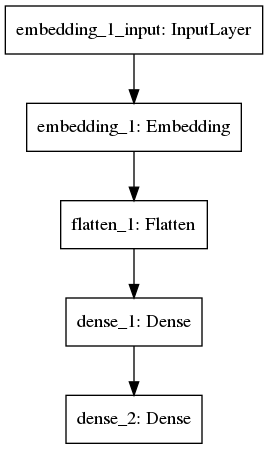

In [7]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

# Train the Model

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_mat, y_train, batch_size=batch_size, epochs=30, validation_split=0.1, callbacks=[es])

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 129 samples, validate on 15 samples
Epoch 1/30
129/129 [==============================] - 1s 4ms/step - loss: 0.6686 - accuracy: 0.6357 - val_loss: 0.5825 - val_accuracy: 0.7333
Epoch 2/30
129/129 [==============================] - 0s 112us/step - loss: 0.3238 - accuracy: 0.9302 - val_loss: 0.5646 - val_accuracy: 0.7333
Epoch 3/30
129/129 [==============================] - 0s 124us/step - loss: 0.1818 - accuracy: 0.9922 - val_loss: 0.5656 - val_accuracy: 0.7333
Epoch 4/30
129/129 [==============================] - 0s 122us/step - loss: 0.0817 - accuracy: 1.0000 - val_loss: 0.5647 - val_accuracy: 0.7333
Epoch 5/30
129/129 [==============================] - 0s 113us/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.5629 - val_accuracy: 0.7333
Epoch 6/30
129/129 [==============================] - 0s 112us/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.5680 - val_accuracy: 0.7333
Epoch 7/30
129/129 [==============================] - 0s 117us/step - loss: 0.0085 - accuracy

# Evaluate the model

In [9]:
score, acc = model.evaluate(X_test_mat, y_test, batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 0s 81us/step
Test score: 0.7076615191794731
Test accuracy: 0.6756756901741028


# Make predictions

In [10]:
import numpy as np

predictions = model.predict(X_test_mat)
np.where(predictions > 0.5, 1, 0).flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])